# CHE1147 Data Mining in Engineering
### Assignment 4 Jialin Shang 1005086256
## 2. Batch data analysis

In this problem, we will look into batch data; dynamic time-series of a finite duration 2. Batch
manufacturing processes are very common in chemical, pharma, bioengineering and semi-
conductor industries such as baker’s yeast production, beer brewing and vaccines production.
In theory, a reactor is designed with temperature, pressure, level, pH control and multiple
sensors that measure these variables among others. A perfect batch (again in theory) is one
that is tightly controlled to the specifications and as a result the productivity and quality of
the final product is optimized.
In real life, a typical batch is run from a few hours up to a week or two and a lot of things
can go wrong during this period. There is always variability either because the process is
very sensitive to minor fluctuations in some variables or the control of some variables failed
for a period of time.
In a company that implements Data Analytics or Multivariate Statistical Process Control
(MSPC) monitoring is typically implemented with the following steps:


1. Identify a number of reference, perfect historical batches (15-20), both in terms of high productivity/quality and minimum anomalies or fluctuations around the setpoints.
2. Create a PCA model of the perfect batches identified. This is your model.
3. Every time your site is running a new batch, fit your data online or as soon as your data infrastructure allows you to do so. Fitting will tell you whether your batch is similar to the perfect batches or it is deviating from the reference behaviour.

Next, you will follow these steps to build a Batch Statistical Process Control and implement
it to monitor a new batch (we will assume that you got the data at the end of the batch
and fit them to the model). The dataset is from a baker’s yeast production facility in Solna,
Sweden capturing the last step of the fermentation.

### 2.1 Build a Batch Statistical Process Control model

1. Import the data from ’bakers yeast reference batches.xlsx’. Identify how many batches are in the data. What is the duration of each batch and how many data points are there per batch? How many variables are measured (including time)?

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler, StandardScaler 
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# Import dataset
b = pd.read_excel('bakers_yeast_reference_batches.xlsx')
b.head()

,Unnamed: 0,Primary ID,BatchID,Time,Ethanol,Temperature,Molasses flow,NH3 flow,Air flow,Level,pH
0,249,250,bb,0.000000,0.05059,31.9580,212.328,6.16453,1382.19,43.4194,5.85607
1,250,251,bb,0.166667,0.04930,31.5303,835.476,29.78270,2084.42,43.4853,5.34603
2,251,252,bb,0.333333,0.04973,30.8220,910.155,32.50710,2266.47,43.5628,5.18718
3,252,253,bb,0.500000,0.04915,30.1617,985.011,36.37100,2446.84,43.6002,5.18043
4,253,254,bb,0.666667,0.04744,29.8891,1052.450,39.26990,2636.96,43.6572,5.18145


In [3]:
# Find number and name of batches
print('The number of batches is:', len(b.BatchID.unique()), 'and they are:', b.BatchID.unique())

The number of batches is: 16 and they are: ['bb' 'cb' 'db' 'eb' 'fb' 'gb' 'hb' 'ib' 'jb' 'kb' 'lb' 'Ma' 'Na' 'Ta'
 'Va' 'Xa']


In [4]:
# Find the duration of each batch 
print('The duration of each batch is:', b.groupby('BatchID').Time.max()) 

The duration of each batch is: BatchID
Ma    13.6667
Na    13.6667
Ta    13.6667
Va    13.6667
Xa    13.6667
bb    13.6667
cb    13.6667
db    13.6667
eb    13.6667
fb    13.6667
gb    13.6667
hb    13.6667
ib    13.6667
jb    13.6667
kb    13.6667
lb    13.6667
Name: Time, dtype: float64


In [5]:
# Find the number of data points in each batch
print('The number of data points in each batch is:', b.groupby('BatchID').Time.count())

The number of data points in each batch is: BatchID
Ma    83
Na    83
Ta    83
Va    83
Xa    83
bb    83
cb    83
db    83
eb    83
fb    83
gb    83
hb    83
ib    83
jb    83
kb    83
lb    83
Name: Time, dtype: int64


In [6]:
# Find the number of variables are measured (including time)
print('The number of variables are measured (including time) is 8. And they are Time, Ethanol, Temperature, Molasses flow, NH3 flow, Air flow, Level, pH')

The number of variables are measured (including time) is 8. And they are Time, Ethanol, Temperature, Molasses flow, NH3 flow, Air flow, Level, pH


2. Plot the variables time-profiles in a 2x4 subplot. Inspect the graphs (don’t just plot them). Look for potential outliers. Which variables have the largest variability? Which variables are tightly controlled?

Text(0, 0.5, 'pH')

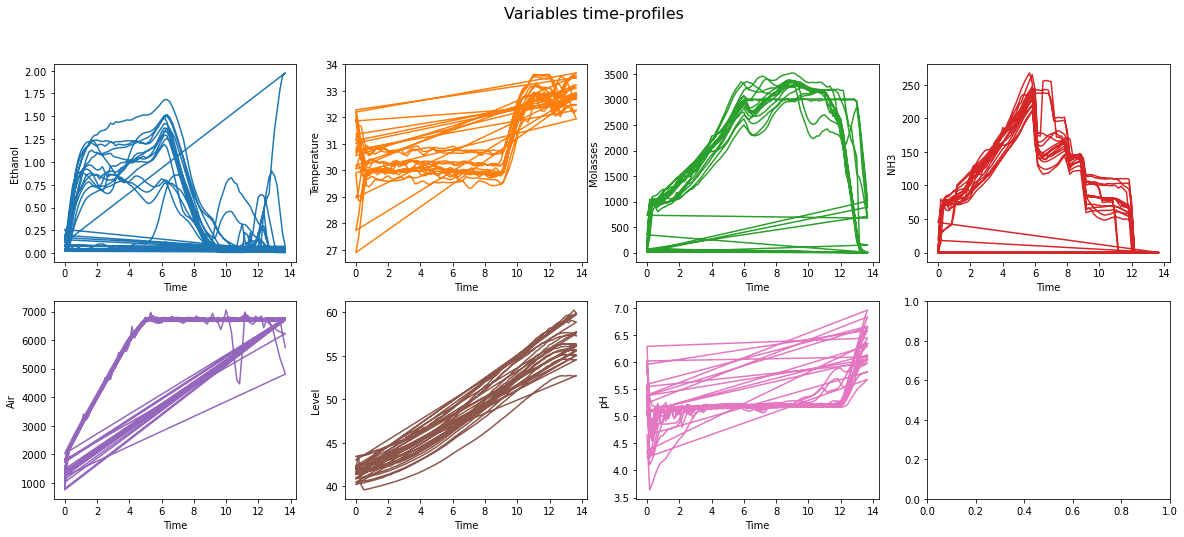

In [8]:
# Plot the variables time-profiles in a 2x4 subplot. 
time = b.iloc[:,3].values
Ethanol = b.iloc[:,4].values
Temperature = b.iloc[:,5].values
Molasses = b.iloc[:,6].values
NH3 = b.iloc[:,7].values
Air = b.iloc[:,8].values
Level = b.iloc[:,9].values
pH = b.iloc[:,10].values

fig, ((ax11, ax12, ax13,ax14),(ax21,ax22,ax23,ax24)) = plt.subplots(2, 4, figsize = (20,8))
fig.suptitle('Variables time-profiles', fontsize = 16)

ax11.plot(time, Ethanol)
ax11.set_xlabel('Time')
ax11.set_ylabel('Ethanol')

ax12.plot(time, Temperature, 'tab:orange')
ax12.set_xlabel('Time')
ax12.set_ylabel('Temperature')

ax13.plot(time, Molasses, 'tab:green')
ax13.set_xlabel('Time')
ax13.set_ylabel('Molasses')

ax14.plot(time, NH3, 'tab:red')
ax14.set_xlabel('Time')
ax14.set_ylabel('NH3')

ax21.plot(time, Air, 'tab:purple')
ax21.set_xlabel('Time')
ax21.set_ylabel('Air')

ax22.plot(time, Level, 'tab:brown')
ax22.set_xlabel('Time')
ax22.set_ylabel('Level')

ax23.plot(time, pH, 'tab:pink')
ax23.set_xlabel('Time')
ax23.set_ylabel('pH')

From the above 7 subplots, we can clearly identify that there are some outliers existing in certain batches' features, such as Air, Molasses & NH3. And the rest are controlled. For more detailed information, we can check variabilities among time and batches. 

For time: the largest variability should be Air because the change in Air is from 1000 to nearly 7000. For batches: Ethanol has the largest variability because it fluctuates too much. 

3. Select the features (including the Time column), pre-process the data and perform
PCA with 5 principal components. Extract the scores and loadings.

In [9]:
# Construct a new dataframe called nb contains selected features including the Time column
nb = b.iloc[:, 3:11]
# Pre-pocess the data and perform PCA with 5 principle components
scaler = StandardScaler()
sb = scaler.fit_transform(nb)
pca = PCA(n_components = 5)
pca_scores = pca.fit_transform(sb)

In [10]:
# Extract the scores
scores_nb = pd.DataFrame(data = pca_scores,columns = ['PC1', 'PC2', 'PC3','PC4','PC5'],index = nb.index)
scores_nb

,PC1,PC2,PC3,PC4,PC5
0,-0.808176,4.508288,-0.200368,1.295502,-0.754945
1,-1.303347,3.391210,0.824346,0.666865,-0.552935
2,-1.630004,3.073121,1.085677,0.706676,-0.168488
3,-1.790453,2.816650,1.059588,0.979711,0.160562
4,-1.811100,2.636318,1.033483,1.094550,0.294213
...,...,...,...,...,...
1323,3.772295,2.368292,-1.644665,0.830572,-0.163892
1324,3.875235,2.595895,-1.942104,0.980115,-0.265168
1325,3.963794,2.665704,-2.074648,1.041445,-0.323446
1326,3.900935,2.872436,-2.046092,1.108283,-0.312934


In [11]:
# Extract the loadings
loadings_nb = pd.DataFrame(data = pca.components_.T,columns = ['PC1', 'PC2','PC3', 'PC4','PC5'] ,index = nb.columns)
loadings_nb

,PC1,PC2,PC3,PC4,PC5
Time,0.471425,-0.115005,-0.073487,-0.109928,0.166210
Ethanol,-0.315056,-0.164245,-0.630171,-0.587107,0.255200
Temperature,0.399243,0.203158,0.051128,-0.540846,-0.647797
Molasses flow,0.127401,-0.608623,0.366748,-0.045936,0.239382
NH3 flow,-0.254209,-0.542698,-0.115348,0.249949,-0.618487
Air flow,0.318021,-0.481637,-0.256120,-0.079962,-0.044048
Level,0.472402,-0.064508,0.060503,-0.001973,0.210803
pH,0.337563,0.132078,-0.614657,0.528890,-0.037395


4. In order to plot the scores-loading plot, you need to pivot the scores BatchID with
index ’Time’ (use pandas pivot table).

In [12]:
# Pivot the scores BatchID with index 'Time' (use pandas pivot table)
BatchID = np.array(b['BatchID'])
Time = np.array(b['Time'])
scores_nb['BatchID'] = BatchID.tolist()
scores_nb['Time'] = Time.tolist()
scores_pt = pd.pivot_table(scores_nb, values = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index = 'Time', columns = 'BatchID')
scores_pt

PC1                                                    \
BatchID          Ma        Na        Ta        Va        Xa        bb   
Time                                                                    
0.000000  -2.575226 -2.494768 -1.834810 -1.935067 -1.953438 -0.808176   
0.166667  -3.406333 -2.944182 -2.731785 -1.704701 -3.044833 -1.303347   
0.333333  -3.390333 -3.070940 -3.117042 -1.841620 -3.172201 -1.630004   
0.500000  -3.534499 -2.888284 -3.194946 -2.016330 -2.751431 -1.790453   
0.666667  -3.596972 -2.732277 -3.165646 -2.107667 -2.436144 -1.811100   
...             ...       ...       ...       ...       ...       ...   
13.000000  2.489762  4.277071  3.184812  4.033208  3.772295  4.373225   
13.166700  2.481818  4.552587  3.157697  4.097282  3.875235  4.485736   
13.333300  2.421492  4.641010  3.372776  4.055942  3.963794  4.556764   
13.500000  2.397535  4.702980  3.579729  4.048033  3.900935  4.617689   
13.666700  2.442108  4.826890  3.850841  3.985137  3.808085  4.695344   

                                                   ...       PC5            \
BatchID          cb        db        eb        fb  ...        cb        db   
Time                                               ...                       
0.000000  -1.732160 -1.483465 -2.607604 -2.574646  ... -0.132314  0.132039   
0.166667  -2.818163 -2.245863 -3.134312 -3.146375  ... -0.526101  0.060107   
0.333333  -3.018590 -3.095891 -3.340362 -3.181104  ... -0.346720  0.127723   
0.500000  -2.938017 -3.043336 -3.349177 -2.775636  ... -0.083581  0.355656   
0.666667  -2.735993 -2.909978 -3.199772 -2.511582  ...  0.060130  0.456512   
...             ...       ...       ...       ...  ...       ...       ...   
13.000000  3.610527  3.231240  3.730375  3.293611  ... -0.289543 -0.039956   
13.166700  3.812695  3.385515  3.900761  3.531415  ... -0.436381 -0.158290   
13.333300  4.008694  3.523197  4.035689  3.730366  ... -0.528557 -0.196414   
13.500000  4.187002  3.613033  4.143437  3.877819  ... -0.574028 -0.223224   
13.666700  4.289330  3.696612  4.246451  3.984240  ... -0.582936 -0.218157   

                                                                       \
BatchID          eb        fb        gb        hb        ib        jb   
Time                                                                    
0.000000  -0.617059  0.897800  0.128482  0.009076 -0.914290  1.438659   
0.166667  -0.570277  0.552050 -0.165896 -0.371143 -1.111206  0.774914   
0.333333  -0.087732  0.075650 -0.462843 -0.755104 -0.431340  0.456887   
0.500000   0.197882 -0.306487 -0.344080 -0.594513 -0.052315  0.199308   
0.666667   0.370031 -0.384769 -0.106633 -0.404393  0.123296  0.218693   
...             ...       ...       ...       ...       ...       ...   
13.000000 -0.292699 -0.656136 -0.236875 -0.491489 -0.158960 -0.126855   
13.166700 -0.372398 -0.775162 -0.341100 -0.588635 -0.269508 -0.242682   
13.333300 -0.404784 -0.839552 -0.399807 -0.637534 -0.309537 -0.286531   
13.500000 -0.430634 -0.870686 -0.438777 -0.664983 -0.323551 -0.338967   
13.666700 -0.446849 -0.863928 -0.430286 -0.667053 -0.351098 -0.322251   

                               
BatchID          kb        lb  
Time                           
0.000000   1.833015 -0.111854  
0.166667   1.236314 -0.332924  
0.333333   0.850361 -0.270976  
0.500000   0.471139 -0.038183  
0.666667   0.224946  0.038438  
...             ...       ...  
13.000000 -0.147775 -0.175886  
13.166700 -0.292980 -0.289735  
13.333300 -0.326307 -0.334636  
13.500000 -0.322784 -0.355440  
13.666700 -0.327004 -0.367125  

[83 rows x 80 columns]

5. Plot the scores-loadings plot with one line per batch (this is why the pivot in the
previous step was needed). The output should look similar to the plot below. You
may choose a different scaling, but the trend should be the same as this graph.

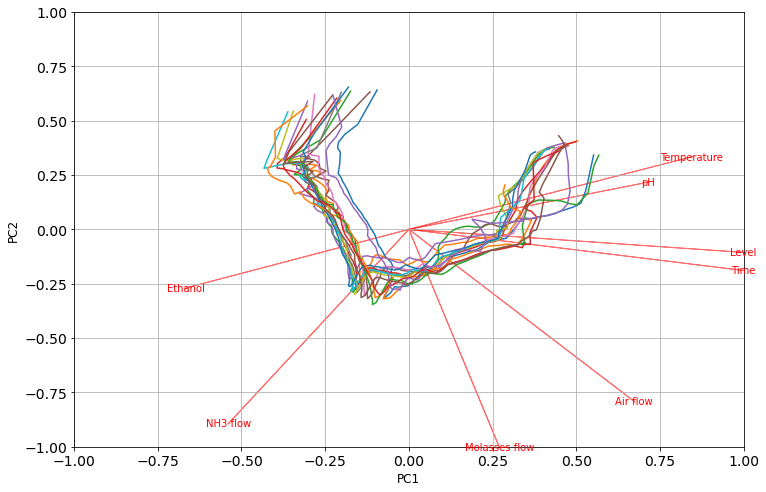

In [14]:
def myplotq5(scores, loadings, loading_labels = None, score_labels = None):

    xt = scores[:,0]
    yt = scores[:,1]
    
    n = loadings.shape[0]
    
    scalext = 1.0/(xt.max() - xt.min())
    scaleyt = 1.0/(yt.max() - yt.min())
    
    xt_scaled = xt * scalext
    yt_scaled = yt * scaleyt
    
    p = loadings
    scaled_p = MaxAbsScaler().fit_transform(p)

    for a in range(16):
        plt.plot(xt_scaled[a * 83: (a + 1) * 83], yt_scaled[a * 83: (a + 1) * 83])
    
    for b in range(n):
        plt.arrow(0, 0, scaled_p[b, 0], scaled_p[b, 1], color = 'r', alpha = 0.5)
        if loading_labels is None:
            plt.text(scaled_p[b, 0], scaled_p[b, 1], "Var"+str(b + 1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(scaled_p[b, 0], scaled_p[b, 1], loading_labels[b], color = 'r', ha = 'center', va = 'center')
    
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    
    plt.xlabel("PC{}".format(1), fontsize = 12);
    plt.ylabel("PC{}".format(2), fontsize = 12);
    
    plt.tick_params(labelsize = 14)
    plt.grid()

plt.rcParams["figure.figsize"] = [12, 8]
myplotq5(pca_scores[:,:2], loadings_nb.iloc[:,:2], loading_labels = loadings_nb.index,score_labels = scores_nb.index)

6. Explain this graph. In which quarter do the batches start and end? What happens at
the kink where the direction of the lines changes? Can you tell from this graph which
variables do not change in the first phase and which in the second phase?

The batches start in quarter 2 and end in quarter 1. 

The direction changes at the kink point, where some variables change but the rest remain stable. 

In phrase 1, Air and Molasses remain the same. In phrase 2, temperature, ph and ethanol remain the same. 

7. Plot the cumulative explained variance. How much variance do the first two principal
components capture?

Text(0.5, 1.0, 'Cumulative Explained Variance')

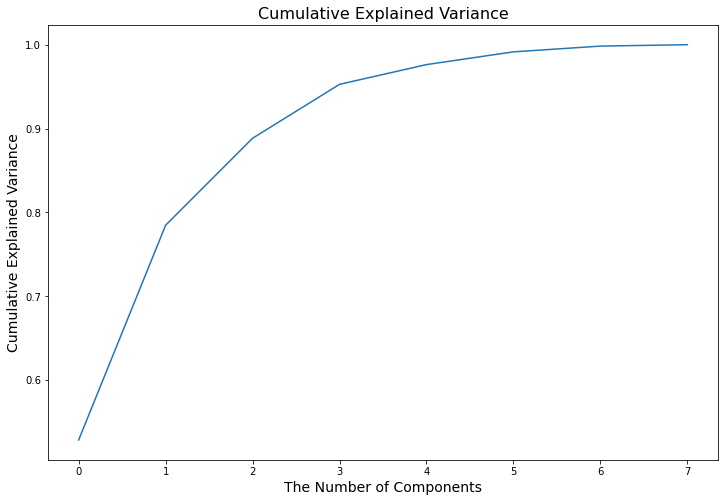

In [15]:
# Plot the cumulative explained variance graph
pca = PCA().fit(sb)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('The Number of Components', fontsize = 14)
plt.ylabel('Cumulative Explained Variance', fontsize = 14)
plt.title('Cumulative Explained Variance', fontsize = 16)

In [16]:
print('The first 2 components capture', np.cumsum(pca.explained_variance_ratio_)[1] * 100, 'percent of the variance.')

The first 2 components capture 78.46737653782884 percent of the variance.


### 2.2 Use the model to monitor running batches

The goal of building an unsupervised model is to monitor the running batches. Your site
runs two reactors in parallel and here you will fit the data from these two reactors to the
model previously built and identify potential problems and outliers3

1. Load the data from the file ’todays batches.xlsx’ and repeat the same procedure as in
the steps 3-4 of the previous section with the exception of the PCA modeling. Here,
instead of fit the data to the model and transform, you will only transform them with
the model object you created in the previous section.

In [17]:
# Import the dataset
t = pd.read_excel('todays_batches.xlsx')
t

,Unnamed: 0,Primary ID,BatchID,Time,Ethanol,Temperature,Molasses flow,NH3 flow,Air flow,Level,pH
0,2573,2574,Ya,0.000000,0.30350,29.0885,-0.70954,0.00356,1250.69,41.9216,4.86282
1,2574,2575,Ya,0.166667,0.41224,29.5509,-1.49002,0.00712,2040.08,41.9911,4.00324
2,2575,2576,Ya,0.333333,1.16614,29.9639,-1.63193,0.00712,2235.08,42.3624,4.05839
3,2576,2577,Ya,0.500000,2.22696,29.9746,1280.07000,82.08680,2419.08,42.8531,4.35465
4,2577,2578,Ya,0.666667,3.13590,29.9466,844.09600,74.65800,2603.53,43.2146,4.76967
...,...,...,...,...,...,...,...,...,...,...,...
161,2734,2735,Za,13.000000,0.01637,33.2882,301.55000,0.05000,6794.76,57.2191,6.38039
162,2735,2736,Za,13.166700,0.01575,33.3834,161.95900,0.04286,6820.50,57.2289,6.48979
163,2736,2737,Za,13.333300,0.01512,33.4438,75.58330,0.03214,6698.80,57.2021,6.55989
164,2737,2738,Za,13.500000,0.01444,33.4531,61.79870,0.06429,6775.14,57.0425,6.59559


In [18]:
# Repeat the step 3 & step 4
# Construct a new dataframe called nb contains selected features including the Time column
nt = t.iloc[:, 3:11].copy()
# Pre-pocess the data and perform PCA with 5 principle components
scaler = StandardScaler()
st = scaler.fit_transform(nt)
pca = PCA(n_components = 5)
pca_scores = pca.fit_transform(st)

In [19]:
# Extract the scores
scores_nt = pd.DataFrame(data = pca_scores,columns = ['PC1', 'PC2', 'PC3','PC4','PC5'], index = nt.index)
scores_nt

,PC1,PC2,PC3,PC4,PC5
0,-3.095247,0.858348,3.007975,0.001562,0.792921
1,-3.744019,0.993014,2.492396,-2.191579,0.353511
2,-3.521441,0.796706,2.435251,-2.173744,0.205332
3,-2.990482,1.862780,1.242177,-1.304306,0.102705
4,-2.655627,1.227312,1.426620,-0.287240,0.079666
...,...,...,...,...,...
161,4.038087,-1.557512,1.710055,1.651320,-0.055672
162,4.182185,-1.679932,1.801278,1.908783,-0.143664
163,4.265971,-1.729211,1.908275,2.066825,-0.199880
164,4.311200,-1.771251,1.894597,2.151547,-0.221418


In [20]:
# Extract the loadings
loadings_nt = pd.DataFrame(data = pca.components_.T, columns = ['PC1', 'PC2','PC3', 'PC4','PC5'] ,index = nt.columns)
loadings_nt

,PC1,PC2,PC3,PC4,PC5
Time,0.474224,-0.182056,-0.122818,-0.245844,-0.183772
Ethanol,-0.288549,-0.487908,-0.313743,-0.054727,-0.035690
Temperature,0.463797,-0.004013,0.243016,-0.264771,-0.506081
Molasses flow,0.224908,0.502010,-0.376653,-0.148133,0.539534
NH3 flow,-0.037937,0.542617,-0.449081,0.250611,-0.575564
Air flow,0.161048,-0.400095,-0.684261,0.053484,-0.042966
Level,0.507666,-0.056292,-0.025853,-0.137150,0.274860
pH,0.375578,-0.138179,0.122483,0.871804,0.095242


In [21]:
# Pivot the scores BatchID with index 'Time' (use pandas pivot table)
BatchID = np.array(t['BatchID'])
Time = np.array(t['Time'])
scores_nt['BatchID'] = BatchID.tolist()
scores_nt['Time'] = Time.tolist()
scores_ptt = pd.pivot_table(scores_nt, values = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index = 'Time', columns = 'BatchID')
scores_ptt

PC1                 PC2                 PC3            \
BatchID          Ya        Za        Ya        Za        Ya        Za   
Time                                                                    
0.000000  -3.095247 -0.645201  0.858348  0.182692  3.007975  3.742119   
0.166667  -3.744019 -1.861544  0.993014  1.490843  2.492396  2.252612   
0.333333  -3.521441 -2.431072  0.796706  1.860953  2.435251  1.769715   
0.500000  -2.990482 -2.076405  1.862780  1.680338  1.242177  1.844990   
0.666667  -2.655627 -1.838744  1.227312  1.299824  1.426620  2.155217   
...             ...       ...       ...       ...       ...       ...   
13.000000  1.980390  4.038087 -1.014400 -1.557512  0.936131  1.710055   
13.166700  2.033354  4.182185 -1.023144 -1.679932  0.944055  1.801278   
13.333300  2.103901  4.265971 -1.023089 -1.729211  0.970732  1.908275   
13.500000  2.094587  4.311200 -1.185871 -1.771251  1.082753  1.894597   
13.666700  1.882435  4.367412 -1.130862 -1.786885  1.669682  1.907438   

                PC4                 PC5            
BatchID          Ya        Za        Ya        Za  
Time                                               
0.000000   0.001562  3.777105  0.792921  0.745785  
0.166667  -2.191579  1.330811  0.353511  0.433556  
0.333333  -2.173744 -0.453439  0.205332  0.026653  
0.500000  -1.304306 -0.303914  0.102705 -0.173748  
0.666667  -0.287240  0.272754  0.079666 -0.075803  
...             ...       ...       ...       ...  
13.000000 -0.986566  1.651320 -0.256712 -0.055672  
13.166700 -0.888077  1.908783 -0.209877 -0.143664  
13.333300 -0.829092  2.066825 -0.187989 -0.199880  
13.500000 -0.704273  2.151547 -0.315740 -0.221418  
13.666700 -0.486108  2.185166 -0.385101 -0.215792  

[83 rows x 10 columns]

2. Plot the same scores-loadings plot for the data in the batches you used to develop the
model with solid lines. Overlay the new incoming data from the two current batches
with dashed lines and two different colours to distinguish them. Also, add a legend for
the two batches so that the viewer can distinguish them.

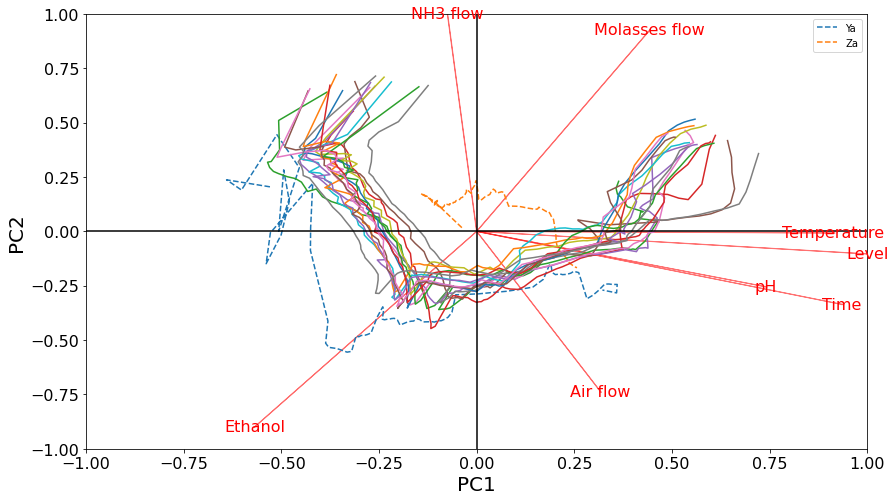

In [26]:
def myplotq2(loadings,scores,scores1,loading_labels):
    xt = scores1.iloc[:,0]
    yt = scores1.iloc[:,2]
          
    batch_name = ['Ya','Za']
    scalext = 1.0/(xt.max() - xt.min() )
    scaleyt = 1.0/(yt.max() - yt.min())
    xt_scaled = xt * scalext
    yt_scaled = yt * scaleyt    
    plt.plot(np.array(xt_scaled),np.array(yt_scaled),'--')

    xt = scores1.iloc[:,1]
    yt = scores1.iloc[:,3]

    scalext = 0.4/(xt.max() - xt.min())
    scaleyt = 0.4/(yt.max() - yt.min())
    xt_scaled = xt * scalext
    yt_scaled = yt * scaleyt    
    plt.plot(np.array(xt_scaled),np.array(yt_scaled),'--')
    plt.legend(batch_name)

    for i in range(16):
      xt = scores.iloc[:,i]
      yt = scores.iloc[:,i+16]
      
      scalext = 1.0/(xt.max() - xt.min())
      scaleyt = 1.0/(yt.max() - yt.min())
      xt_scaled = xt * scalext
      yt_scaled = yt * scaleyt
      plt.plot(np.array(xt_scaled),np.array(yt_scaled))

    n = loadings.shape[0]

    p = loadings
    p_scaled = MaxAbsScaler().fit_transform(p)

    for i in range(n):
        plt.arrow(0, 0, p_scaled[i,0], p_scaled[i,1], color = 'r',alpha = 0.5)
        if loading_labels is None:
            plt.text(p_scaled[i,0], p_scaled[i,1], "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(p_scaled[i,0], p_scaled[i,1], loading_labels[i], color = 'r', ha = 'center', va = 'center', size=16)
    
    
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.axvline(x=0, color='k', linestyle='-')
    plt.xlabel("PC{}".format(1), fontsize=20);
    plt.ylabel("PC{}".format(2), fontsize=20);
    plt.tick_params(labelsize=16)
 
plt.rcParams["figure.figsize"] = [14, 8]
myplotq2(loadings_nt, scores_pt, scores_ptt,loadings_nt.index)

3. Do the batches show behaviour similar to that of the reference ones or there are outliers
indicating potential problems?

The batches show that there exist some outliers which further implies that there are some potential problems. 'Za' has a similar pattern as before while 'Ya' is different. 